## CCA for Convolutional Layers

This notebook walks through applying CCA to convolutional layers

In [1]:
import os, sys
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pickle
import pandas
import gzip

sys.path.append("..")
import cca_core

In [2]:
def _plot_helper(arr, xlabel, ylabel):
    plt.plot(arr, lw=2.0)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid()

In the introduction tutorial, we looked at a simple way of thinking of neural network representations (neurons as activation vectors and layers as subspaces) and the applicability of CCA as way to analyze these representations.

Convolutional layers have a different structure, and require a slightly different application of CCA. In the [original paper](https://arxiv.org/abs/1706.05806), we had proposed using a Discrete Fourier Transform to speed up computations for convolutional layers.

Since then, we've identified methods that are even simpler to use when applying CCA to Convolutional layers. We'll work through some of these methods using a conv network for SVHN. 

### Convolutional Layers
First, a quick recap on convolutional layers.


![conv_layer](conv_layer.jpeg)

(Picture Source: an excellent [tutorial](http://cs231n.github.io/convolutional-networks/) on conv nets.)

As shown above, conv nets have a 3D structure, (height, width, num_channels). The height, width are sometimes called the _spatial_ dimensions of the layer. Parameters are shared across the spatial dimensions, so the degrees of freedom of the conv layer come from the number of channels it has. 

As a result, we'll want to compare the the similarity of two conv layers _**by comparing across channels**_.

### CCA for Conv Nets with SVHN

SVHN consists of images that are 32 x 32 (height 32, width 32). Our architecture looks like:

**conv1(3x3,32 channels)---maxpool(2x2)---conv2(3x3,64 channels)---maxpool(2x2)---batchnorm---fc(200)---fc(10)**

We've stored activations over 1000 test datapoints for two models. Let's load them up!

In [3]:
# Load up conv 2 activations from SVHN
with gzip.open("./model_activations/SVHN/model_0_lay03.p", "rb") as f:
    acts1 = pickle.load(f)
    
with gzip.open("./model_activations/SVHN/model_1_lay03.p", "rb") as f:
    acts2 = pickle.load(f)

print(acts1.shape, acts2.shape)

(1000, 16, 16, 64) (1000, 16, 16, 64)


These activations have shape: (number datapoints, height, width, num channels). The spatial dimensions (height, width) share parameters, and so to compare two conv layers, we want to be able to compare the representations learned in their channels.

There are a few ways of doing this, depending on the shapes of the layers being compared.

### Comparing Conv Layers with the Same Spatial Dimensions

If the two conv layers being compared have the same spatial dimensions, we can flatten the spatial dimensions into the number of datapoints:

In [4]:
num_datapoints, h, w, channels = acts1.shape
f_acts1 = acts1.reshape((num_datapoints*h*w, channels))

num_datapoints, h, w, channels = acts2.shape
f_acts2 = acts2.reshape((num_datapoints*h*w, channels))

print(f_acts1.shape, f_acts2.shape)

(256000, 64) (256000, 64)


The motivation for doing this is that each spatial location (i, j) in a channel sees a different image patch, and so is like an additional datapoint. 

Now we can apply CCA across the channels (remembering to transpose the flattened activations)

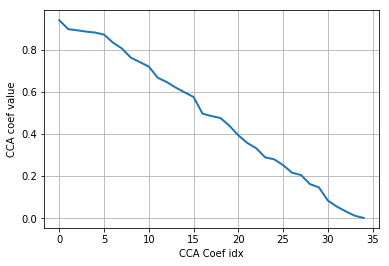

In [5]:
f_results = cca_core.get_cca_similarity(f_acts1.T, f_acts2.T, epsilon=1e-10, verbose=False)
_plot_helper(f_results["cca_coef1"], "CCA Coef idx", "CCA coef value")

 We can also do this after subsampling some of the datapoints to reduce computation overheads. The results are  very stable to this as the number of channels we have (64) is _significantly_ smaller than the number of datapoints: 1000 x 16 x16. 

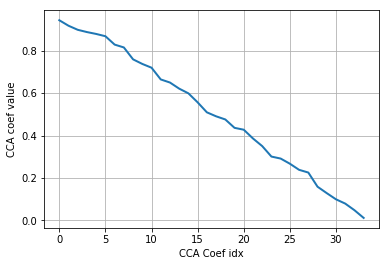

In [6]:
f_results = cca_core.get_cca_similarity(f_acts1.T[:,::2], f_acts2.T[:,::2], epsilon=1e-10, verbose=False)
_plot_helper(f_results["cca_coef1"], "CCA Coef idx", "CCA coef value")

### Conv Layers with Different Spatial Dimensions

Suppose our two conv layers have different spatial dimensions:

In [7]:
with gzip.open("./model_activations/SVHN/model_1_lay04.p", "rb") as f:
    pool2 = pickle.load(f)
    
print("shape of first conv", acts1.shape, "shape of second conv", pool2.shape)

shape of first conv (1000, 16, 16, 64) shape of second conv (1000, 8, 8, 64)


Here we want to compare conv2 in model 0 with the maxpool activations in model 1. We can't just turn the spatial dimensions into datapoints like before, because then the number of datapoints will be different for each layer. Remember, CCA can make comparisons across _different_ numbers of neurons (in our case different numbers of channels) but the data dimension has to be the same.

There are a couple of other simple things we can do though.

#### Average Pool

The simplest thing one can do (can also be used when conv layers have the same spatial dimensions) is to perform an average pool over spatial dimensions. This can often work relatively well:

shapes after average pool over spatial dimensions (1000, 64) (1000, 64)


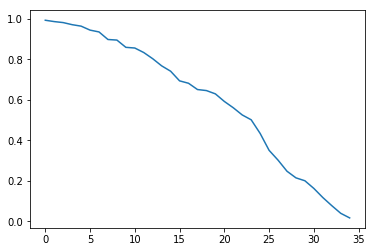

In [7]:
avg_acts1 = np.mean(acts1, axis=(1,2))
avg_pool2 = np.mean(pool2, axis=(1,2))

print("shapes after average pool over spatial dimensions", avg_acts1.shape, avg_pool2.shape)
a_results = cca_core.get_cca_similarity(avg_acts1.T, avg_pool2.T, epsilon=1e-10, verbose=False)
_plot_helper(a_results["cca_coef1"], "CCA Coef idx", "CCA coef value")

#### Interpolate

Another thing one can do is to interpolate the spatial dimensions of the smaller sized conv layer so that they match the large layer. There are many ways to do this, and the `interpolate` library in `scipy` provides access to many different methods.

In [8]:
from scipy import interpolate

num_d, h, w, _ = acts1.shape
num_c = pool2.shape[-1]
pool2_interp = np.zeros((num_d, h, w, num_c))

for d in range(num_d):
    for c in range(num_c):
        # form interpolation function
        idxs1 = np.linspace(0, pool2.shape[1],
                            pool2.shape[1],
                            endpoint=False)
        idxs2 = np.linspace(0, pool2.shape[2],
                            pool2.shape[2],
                            endpoint=False)
        arr = pool2[d,:,:,c]
        f_interp = interpolate.interp2d(idxs1, idxs2, arr)
        
        # creater larger arr
        large_idxs1 = np.linspace(0, pool2.shape[1],
                            acts1.shape[1],
                            endpoint=False)
        large_idxs2 = np.linspace(0, pool2.shape[2],
                            acts1.shape[2],
                            endpoint=False)
        
        pool2_interp[d, :, :, c] = f_interp(large_idxs1, large_idxs2)

print("new shape", pool2_interp.shape)

new shape (1000, 16, 16, 64)


For this example, we just used the default interpolation (linear) in the `interp2d` function. There are many different interpolations possible that would be interesting to explore.

Now that our two layers have the same spatial shape, we can proceed as we did before

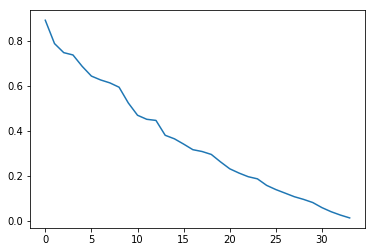

In [9]:
num_datapoints, h, w, channels = acts1.shape
f_acts1 = acts1.reshape((num_datapoints*h*w, channels))

num_datapoints, h, w, channels = pool2_interp.shape
f_pool2 = pool2_interp.reshape((num_datapoints*h*w, channels))

f_results = cca_core.get_cca_similarity(f_acts1.T[:,::5], f_pool2.T[:,::5], epsilon=1e-10, verbose=False)
plt.plot(f_results["cca_coef1"])


### Summary
In this tutorial, we learned about how to apply CCA to compare convolutional layers to each other. The main point is that for conv layers, we'd like to do comparisons across channels. There are a few options:
1. Average pool over spatial locations, then compare channels. This works for same spatial sized and different spatial sized conv layers.
2. Fold the spatial dimensions into the data dimension, and compare. This works for same spatial sized conv layers, and the intution behind it is that different spatial locations see different image patches.
3. For different spatial sized conv layers, we can first perform an interpolation to make them the same size, and then compare with either of the two methods above.